In [2]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('../src/models/gen/iMT1026-v3.1.xml')
%run -i create_pathway.ipynb  # runs other script with included function to alter model

In [3]:
with model:
    model2 = model.copy()
    create_pathway(model2,1)

Added beta alanine pathway


In [4]:
# Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium = model2.medium
medium['Ex_meoh'] = 6
medium['Ex_glyc'] = 0
model2.medium = medium

In [5]:
# Adding enzyme 4.3.1.1 from Song
new_reaction = Reaction('ASPAML')
new_reaction.add_metabolites({model2.metabolites.fum_c: -1,
                              model2.metabolites.nh4_c: -1,
                              model2.metabolites.asp_L_c: 1,
                              model2.metabolites.h_c: 1,
                             })
model2.add_reactions([new_reaction])


In [6]:
#Fva of malonic-semialdehyde at 50% growth
from cobra.flux_analysis import flux_variability_analysis
with model2:
    
    model2.objective = model.reactions.Ex_biomass 
    specified_growth_rate = 0.5*model2.optimize().objective_value


    constrained_growth = model2.problem.Constraint(
        model2.reactions.get_by_id('Ex_biomass').flux_expression,
        lb=specified_growth_rate,
        ub=specified_growth_rate)
    model2.add_cons_vars(constrained_growth)
    
    model2.objective = model2.reactions.Ex_mln
    solution = model2.optimize()
    print(model2.metabolites.asp_L_c.summary(fva=1.0))

asp_L_c
Formula: C4H6NO4

Producing Reactions
-------------------
Percent   Flux            Range  Reaction                               Definition
  0.00%      0   [0; 5.181E-06]      ASNN      asn_L_c + h2o_c --> asp_L_c + nh4_c
  5.97% 0.2416  [0.2416; 996.3]    ASPAML          fum_c + nh4_c --> asp_L_c + h_c
 94.03%  3.804   [3.699; 999.7]  ASPGLU2m  asp_L_m + glu_L_c --> asp_L_c + glu_L_m
  0.00%      0   [0; 5.181E-06]    ASPt2r          asp_L_e + h_e <=> asp_L_c + h_c
  0.00%      0   [-1000; 998.7]    ASPt5n                      asp_L_n <=> asp_L_c

Consuming Reactions
-------------------
Percent      Flux                   Range       Reaction                                                                      Definition
  0.17% -0.006952  [-0.006967; -0.006952]           ADSS                    asp_L_c + gtp_c + imp_c --> dcamp_c + gdp_c + 2.0 h_c + pi_c
  0.24% -0.009763  [-0.009765; -0.009763]         ARGSSr                   asp_L_c + atp_c + citr_L_c <=> amp_c + argsuc_

The solution requires a minimum of 0.2415 of flux through the ASPAML reaction which is a good sign. It does not however change the yield or phenotypic phase plane significantly

<AxesSubplot:xlabel='Ex_biomass'>

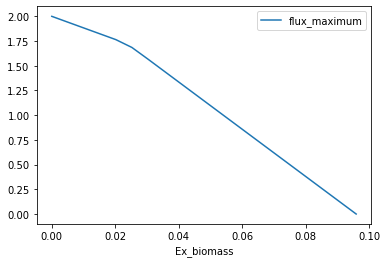

In [7]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
prod_env = production_envelope(model2, ["Ex_biomass"], objective="Ex_mln", carbon_sources="Ex_meoh")
prod_env.plot(x='Ex_biomass',y='flux_maximum')

Next, we introducing ATP forming phosphoenolpyruvate carboxykinase (E.C:  4.1.1.49)

In [8]:
# The enzyme is already present but only in the ADP forming direction
model.reactions.PPCK

Reaction identifier,PPCK
Name,phosphoenolpyruvate carboxykinase
Memory address,0x021a0f3c1c50
Stoichiometry,atp_c + oaa_c --> adp_c + co2_c + pep_c ATP + Oxaloacetate --> ADP + CO2 + Phosphoenolpyruvate
GPR,PAS_FragB_0061
Lower bound,0.0
Upper bound,1000.0


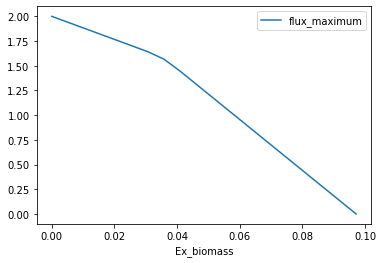

In [47]:
with model2:
    
    # Only allowing ATP forming enzyme to act
    model2.reactions.PPCK.lower_bound=-1000
    model2.reactions.PPCK.upper_bound=0

    model2.objective = model2.reactions.Ex_mln
    solution = model2.optimize()
    

    from cobra.flux_analysis.phenotype_phase_plane import production_envelope
    prod_env = production_envelope(model2, ["Ex_biomass"], objective="Ex_mln", carbon_sources="Ex_meoh")
    prod_env.plot(x='Ex_biomass',y='flux_maximum')
    

The phenotypic phase plane has been improved and higher fluxes of malonate can be reached at smaller growth rates (optimally a flux of 1.566825 mmolMeoH/(gDW*h) at growth of 0.036 (1/h))

In [ ]:
#Fva of malonic-semialdehyde at 50% growth
with model2:
    
    model2.reactions.PPCK.lower_bound=-1000
    model2.reactions.PPCK.upper_bound=0
    
    model2.objective = model.reactions.Ex_biomass 
    specified_growth_rate = 0.5*model2.optimize().objective_value


    constrained_growth = model2.problem.Constraint(
        model2.reactions.get_by_id('Ex_biomass').flux_expression,
        lb=specified_growth_rate,
        ub=specified_growth_rate)
    model2.add_cons_vars(constrained_growth)
    
    model2.objective = model2.reactions.Ex_mln
    solution = model2.optimize()
    print(model2.metabolites.asp_L_c.summary(fva=1.0))
    
    import escher
    from IPython.display import display
    b = escher.Builder(map_json = 'iMM904.Central_carbon_metabolism.json', reaction_data = solution.fluxes.to_dict(),highlight_missing=True, model=model2)
    display(b)

It can be seen that the newly introduced reaction is favored